In [0]:
!pip install hyperas
!pip install hyperopt

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [0]:
import pickle
import pandas as pd
import numpy as np

In [3]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [4]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def data():
  '''
  Data providing function:
  This function is separated from model() so that hyperopt
  won't reload data for each evaluation run.
  '''
  pickle_in = open("/content/drive/My Drive/HAR/X_train.pickle","rb")
  X_train = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("/content/drive/My Drive/HAR/X_test.pickle","rb")
  X_test = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("/content/drive/My Drive/HAR/Y_train.pickle","rb")
  Y_train = pickle.load(pickle_in)
  pickle_in.close()

  pickle_in = open("/content/drive/My Drive/HAR/Y_test.pickle","rb")
  Y_test = pickle.load(pickle_in)
  pickle_in.close()
  return X_train, Y_train, X_test, Y_test

In [0]:
X_train, Y_train, X_test, Y_test = data()

In [7]:
X_train.shape

(7352, 128, 9)

In [0]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='HAR_LSTM_OPT.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('HAR_LSTM_OPT.ipynb')

     |████████████████████████████████| 993kB 43.2MB/s 


In [9]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
7352
6


In [0]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


# Hyperperameter tuning

In [0]:
# Initiliazing the sequential model
def model(X_train, Y_train, X_test, Y_test):
    from keras.models import Sequential
    import keras
    from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
    from keras.layers.core import Dense, Dropout, Flatten
    from keras.layers.normalization import BatchNormalization
    
    timesteps = 128
    input_dim = 9
    n_classes = 6
    model = Sequential()
    # Configuring the parameters
    model.add(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same', input_shape = (timesteps,input_dim)))
    model.add(MaxPooling1D(pool_size={{choice([2,3])}}))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same'))
    model.add(MaxPooling1D(pool_size={{choice([2,3])}}))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
         activation={{choice(['relu', 'sigmoid'])}},padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))

    if {{choice(['three','four'])}} == 'four':
        model.add(Conv1D(filters = {{choice([64,128, 256, 512, 1024])}}, kernel_size={{choice([2,3,4,5])}},
                     activation={{choice(['relu', 'sigmoid'])}},padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
        # model.add(TimeDistributed(BatchNormalization()))
        model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    
    model.add(Dense({{choice([64,128, 256, 512, 1024])}}, activation={{choice(['softmax', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([64,128, 256, 512, 1024])}}, activation={{choice(['softmax', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([64,128, 256, 512, 1024])}}, activation={{choice(['softmax', 'sigmoid'])}}))
    # Adding a dense output layer with sigmoid activation
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(n_classes, activation={{choice(['softmax', 'sigmoid'])}}))

    adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, Y_train,
              batch_size={{choice([16,64,128,256])}},
              nb_epoch=30,
              verbose=2,
              validation_data=(X_test, Y_test))
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [0]:
if __name__ == '__main__':
  best_run, best_model = optim.minimize(model=model,
                                        data=data,
                                        algo=tpe.suggest,
                                        max_evals=30,
                                        notebook_name='HAR_LSTM_OPT',
                                        trials=Trials())
  
  print(best_run)
  print(best_model.summary())

>>> Imports:
#coding=utf-8

try:
    import pickle
except:
    pass

try:
    from google.colab import drive
except:
    pass

try:
    from pydrive.auth import GoogleAuth
except:
    pass

try:
    from pydrive.drive import GoogleDrive
except:
    pass

try:
    from google.colab import auth
except:
    pass

try:
    from oauth2client.client import GoogleCredentials
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Flatten
except:
    pass

try:
    from keras.layers.normalization import BatchNormalization
except:
    pass

try:
    from keras.models import Sequential



W0626 12:56:47.354541 140419024013184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 12:56:47.384180 140419024013184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 12:56:47.391540 140419024013184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 12:56:47.425362 140419024013184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0626 12:56:47.429435 140419024013184 deprecation_wrap

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 10s - loss: 1.7997 - acc: 0.1831 - val_loss: 1.7891 - val_acc: 0.1805

Epoch 2/30
 - 2s - loss: 1.7880 - acc: 0.1868 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 3/30
 - 2s - loss: 1.7866 - acc: 0.1861 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 4/30
 - 2s - loss: 1.7870 - acc: 0.1853 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 5/30
 - 2s - loss: 1.7866 - acc: 0.1878 - val_loss: 1.7898 - val_acc: 0.1822

Epoch 6/30
 - 2s - loss: 1.7860 - acc: 0.1902 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 7/30
 - 2s - loss: 1.7859 - acc: 0.2001 - val_loss: 1.7891 - val_acc: 0.1822

Epoch 8/30
 - 2s - loss: 1.7857 - acc: 0.1938 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 9/30
 - 2s - loss: 1.7865 - acc: 0.1926 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 10/30
 - 2s - loss: 1.7862 - acc: 0.1891 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 11/30
 - 2s - loss: 1.7865 - acc: 0.1953 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 12/30
 - 2s - loss:

W0626 12:57:56.738947 140419024013184 nn_ops.py:4224] Large dropout rate: 0.556238 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0626 12:57:56.863257 140419024013184 nn_ops.py:4224] Large dropout rate: 0.877458 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 10s - loss: 1.7898 - acc: 0.1857 - val_loss: 1.7898 - val_acc: 0.1805

Epoch 2/30
 - 6s - loss: 1.7875 - acc: 0.1843 - val_loss: 1.7891 - val_acc: 0.1822

Epoch 3/30
 - 6s - loss: 1.7862 - acc: 0.1851 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 4/30
 - 6s - loss: 1.7854 - acc: 0.1881 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 5/30
 - 6s - loss: 1.7848 - acc: 0.1908 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 6/30
 - 6s - loss: 1.7844 - acc: 0.1916 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 7/30
 - 6s - loss: 1.7843 - acc: 0.1930 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 8/30
 - 6s - loss: 1.7841 - acc: 0.1923 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 9/30
 - 6s - loss: 1.7841 - acc: 0.1903 - val_loss: 1.7895 - val_acc: 0.1822

Epoch 10/30
 - 6s - loss: 1.7841 - acc: 0.1908 - val_loss: 1.7896 - val_acc: 0.1822

Epoch 11/30
 - 6s - loss: 1.7840 - acc: 0.1916 - val_loss: 1.7897 - val_acc: 0.1822

Epoch 12/30
 - 6s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 8s - loss: 1.8042 - acc: 0.1829 - val_loss: 1.8323 - val_acc: 0.1822

Epoch 2/30
 - 6s - loss: 1.7983 - acc: 0.1906 - val_loss: 1.7900 - val_acc: 0.1822

Epoch 3/30
 - 6s - loss: 1.7963 - acc: 0.1912 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 4/30
 - 6s - loss: 1.7961 - acc: 0.1915 - val_loss: 1.7918 - val_acc: 0.1805

Epoch 5/30
 - 6s - loss: 1.8017 - acc: 0.1789 - val_loss: 1.7891 - val_acc: 0.1805

Epoch 6/30
 - 6s - loss: 1.7990 - acc: 0.1872 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 7/30
 - 6s - loss: 1.8015 - acc: 0.1809 - val_loss: 1.7889 - val_acc: 0.1805

Epoch 8/30
 - 6s - loss: 1.8024 - acc: 0.1923 - val_loss: 1.7891 - val_acc: 0.1822

Epoch 9/30
 - 6s - loss: 1.7987 - acc: 0.1907 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 10/30
 - 6s - loss: 1.7992 - acc: 0.1827 - val_loss: 1.7901 - val_acc: 0.1666

Epoch 11/30
 - 6s - loss: 1.7993 - acc: 0.1827 - val_loss: 1.7902 - val_acc: 0.1822

Epoch 12/30
 - 6s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 3s - loss: 1.7914 - acc: 0.1863 - val_loss: 1.7898 - val_acc: 0.1666

Epoch 2/30
 - 1s - loss: 1.7902 - acc: 0.1859 - val_loss: 1.7937 - val_acc: 0.1822

Epoch 3/30
 - 1s - loss: 1.7874 - acc: 0.1848 - val_loss: 1.7923 - val_acc: 0.1822

Epoch 4/30
 - 1s - loss: 1.7886 - acc: 0.1844 - val_loss: 1.8013 - val_acc: 0.1805

Epoch 5/30
 - 1s - loss: 1.7877 - acc: 0.1897 - val_loss: 1.7897 - val_acc: 0.1805

Epoch 6/30
 - 1s - loss: 1.7873 - acc: 0.1873 - val_loss: 1.7919 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.7870 - acc: 0.1922 - val_loss: 1.7896 - val_acc: 0.1805

Epoch 8/30
 - 1s - loss: 1.7872 - acc: 0.1903 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.7884 - acc: 0.1929 - val_loss: 1.7903 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.7869 - acc: 0.1900 - val_loss: 1.7923 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.7867 - acc: 0.1896 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 4s - loss: 2.0523 - acc: 0.1706 - val_loss: 1.7890 - val_acc: 0.1805

Epoch 2/30
 - 1s - loss: 1.9965 - acc: 0.1684 - val_loss: 1.7907 - val_acc: 0.1805

Epoch 3/30
 - 1s - loss: 1.9710 - acc: 0.1785 - val_loss: 1.7918 - val_acc: 0.1805

Epoch 4/30
 - 1s - loss: 1.9694 - acc: 0.1737 - val_loss: 1.7908 - val_acc: 0.1805

Epoch 5/30
 - 1s - loss: 1.9600 - acc: 0.1727 - val_loss: 1.7924 - val_acc: 0.1822

Epoch 6/30
 - 1s - loss: 1.9391 - acc: 0.1767 - val_loss: 1.7902 - val_acc: 0.1666

Epoch 7/30
 - 1s - loss: 1.9470 - acc: 0.1723 - val_loss: 1.7907 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.9336 - acc: 0.1729 - val_loss: 1.7911 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.9313 - acc: 0.1666 - val_loss: 1.7905 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.9149 - acc: 0.1685 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.9170 - acc: 0.1654 - val_loss: 1.7911 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 4s - loss: 1.7911 - acc: 0.1808 - val_loss: 1.7909 - val_acc: 0.1822

Epoch 2/30
 - 1s - loss: 1.7896 - acc: 0.1881 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 3/30
 - 1s - loss: 1.7885 - acc: 0.1887 - val_loss: 1.7896 - val_acc: 0.1822

Epoch 4/30
 - 1s - loss: 1.7875 - acc: 0.1896 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 5/30
 - 1s - loss: 1.7867 - acc: 0.1914 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 6/30
 - 1s - loss: 1.7860 - acc: 0.1910 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.7855 - acc: 0.1912 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.7852 - acc: 0.1916 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.7850 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.7847 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.7845 - acc: 0.1911 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 6s - loss: 1.7915 - acc: 0.1760 - val_loss: 1.7913 - val_acc: 0.1805

Epoch 2/30
 - 4s - loss: 1.7906 - acc: 0.1870 - val_loss: 1.7909 - val_acc: 0.1822

Epoch 3/30
 - 4s - loss: 1.7899 - acc: 0.1931 - val_loss: 1.7905 - val_acc: 0.1822

Epoch 4/30
 - 4s - loss: 1.7894 - acc: 0.1885 - val_loss: 1.7902 - val_acc: 0.1822

Epoch 5/30
 - 4s - loss: 1.7890 - acc: 0.1843 - val_loss: 1.7899 - val_acc: 0.1822

Epoch 6/30
 - 4s - loss: 1.7882 - acc: 0.1945 - val_loss: 1.7897 - val_acc: 0.1822

Epoch 7/30
 - 4s - loss: 1.7878 - acc: 0.1895 - val_loss: 1.7895 - val_acc: 0.1822

Epoch 8/30
 - 4s - loss: 1.7877 - acc: 0.1897 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 9/30
 - 4s - loss: 1.7869 - acc: 0.1933 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 10/30
 - 4s - loss: 1.7871 - acc: 0.1866 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 11/30
 - 4s - loss: 1.7862 - acc: 0.1885 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 12/30
 - 4s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 5s - loss: 1.8338 - acc: 0.1790 - val_loss: 1.8388 - val_acc: 0.1666

Epoch 2/30
 - 2s - loss: 1.8184 - acc: 0.1813 - val_loss: 1.8125 - val_acc: 0.1666

Epoch 3/30
 - 2s - loss: 1.8098 - acc: 0.1776 - val_loss: 1.8113 - val_acc: 0.1666

Epoch 4/30
 - 2s - loss: 1.8005 - acc: 0.1832 - val_loss: 1.8224 - val_acc: 0.1598

Epoch 5/30
 - 2s - loss: 1.7990 - acc: 0.1723 - val_loss: 1.8079 - val_acc: 0.1666

Epoch 6/30
 - 2s - loss: 1.7953 - acc: 0.1810 - val_loss: 1.8103 - val_acc: 0.1822

Epoch 7/30
 - 2s - loss: 1.7941 - acc: 0.1840 - val_loss: 1.7931 - val_acc: 0.1805

Epoch 8/30
 - 2s - loss: 1.7917 - acc: 0.1812 - val_loss: 1.7922 - val_acc: 0.1666

Epoch 9/30
 - 2s - loss: 1.7895 - acc: 0.1842 - val_loss: 1.7931 - val_acc: 0.1805

Epoch 10/30
 - 2s - loss: 1.7895 - acc: 0.1775 - val_loss: 1.7913 - val_acc: 0.1805

Epoch 11/30
 - 2s - loss: 1.7895 - acc: 0.1836 - val_loss: 1.7928 - val_acc: 0.1666

Epoch 12/30
 - 2s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 4s - loss: 1.7917 - acc: 0.1751 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 2/30
 - 1s - loss: 1.7917 - acc: 0.1779 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 3/30
 - 1s - loss: 1.7917 - acc: 0.1919 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 4/30
 - 1s - loss: 1.7916 - acc: 0.1910 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 5/30
 - 1s - loss: 1.7916 - acc: 0.1919 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 6/30
 - 1s - loss: 1.7915 - acc: 0.1912 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.7915 - acc: 0.1927 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.7915 - acc: 0.1903 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.7914 - acc: 0.1914 - val_loss: 1.7915 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.7914 - acc: 0.1922 - val_loss: 1.7915 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.7914 - acc: 0.1915 - val_loss: 1.7915 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 5s - loss: 1.7898 - acc: 0.1805 - val_loss: 1.7894 - val_acc: 0.1805

Epoch 2/30
 - 1s - loss: 1.7879 - acc: 0.1785 - val_loss: 1.7889 - val_acc: 0.1805

Epoch 3/30
 - 1s - loss: 1.7870 - acc: 0.1888 - val_loss: 1.7887 - val_acc: 0.1805

Epoch 4/30
 - 1s - loss: 1.7860 - acc: 0.1843 - val_loss: 1.7888 - val_acc: 0.1805

Epoch 5/30
 - 1s - loss: 1.7860 - acc: 0.1854 - val_loss: 1.7888 - val_acc: 0.1805

Epoch 6/30
 - 1s - loss: 1.7858 - acc: 0.1972 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.7858 - acc: 0.1922 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.7861 - acc: 0.1873 - val_loss: 1.7887 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.7851 - acc: 0.1941 - val_loss: 1.7886 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.7847 - acc: 0.1902 - val_loss: 1.7884 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.7847 - acc: 0.1984 - val_loss: 1.7884 - val_acc: 0.2019

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 5s - loss: 1.8133 - acc: 0.1636 - val_loss: 1.7918 - val_acc: 0.1591

Epoch 2/30
 - 1s - loss: 1.8009 - acc: 0.1684 - val_loss: 1.7918 - val_acc: 0.1598

Epoch 3/30
 - 1s - loss: 1.8038 - acc: 0.1639 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 4/30
 - 1s - loss: 1.8077 - acc: 0.1651 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 5/30
 - 1s - loss: 1.8036 - acc: 0.1619 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 6/30
 - 1s - loss: 1.8122 - acc: 0.1620 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 7/30
 - 1s - loss: 1.8088 - acc: 0.1623 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 8/30
 - 1s - loss: 1.7989 - acc: 0.1644 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 9/30
 - 1s - loss: 1.8054 - acc: 0.1640 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 10/30
 - 1s - loss: 1.8051 - acc: 0.1623 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 11/30
 - 1s - loss: 1.8080 - acc: 0.1695 - val_loss: 1.7918 - val_acc: 0.1683

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 7s - loss: 1.7909 - acc: 0.1850 - val_loss: 1.7908 - val_acc: 0.1822

Epoch 2/30
 - 3s - loss: 1.7895 - acc: 0.1921 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 3/30
 - 3s - loss: 1.7882 - acc: 0.1914 - val_loss: 1.7896 - val_acc: 0.1822

Epoch 4/30
 - 3s - loss: 1.7874 - acc: 0.1914 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 5/30
 - 3s - loss: 1.7866 - acc: 0.1912 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 6/30
 - 3s - loss: 1.7860 - acc: 0.1914 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 7/30
 - 3s - loss: 1.7856 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 8/30
 - 3s - loss: 1.7852 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 9/30
 - 3s - loss: 1.7849 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 10/30
 - 3s - loss: 1.7847 - acc: 0.1914 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 11/30
 - 3s - loss: 1.7845 - acc: 0.1914 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 12/30
 - 3s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 5s - loss: 3.7009 - acc: 0.1689 - val_loss: 1.7966 - val_acc: 0.1666

Epoch 2/30
 - 1s - loss: 3.4078 - acc: 0.1717 - val_loss: 1.7970 - val_acc: 0.1805

Epoch 3/30
 - 1s - loss: 3.1306 - acc: 0.1779 - val_loss: 1.7981 - val_acc: 0.1805

Epoch 4/30
 - 1s - loss: 2.9126 - acc: 0.1755 - val_loss: 1.7976 - val_acc: 0.1822

Epoch 5/30
 - 1s - loss: 2.7381 - acc: 0.1733 - val_loss: 1.7974 - val_acc: 0.1805

Epoch 6/30
 - 1s - loss: 2.5777 - acc: 0.1757 - val_loss: 1.8031 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 2.4324 - acc: 0.1639 - val_loss: 1.7991 - val_acc: 0.1805

Epoch 8/30
 - 1s - loss: 2.2824 - acc: 0.1688 - val_loss: 1.8038 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 2.1970 - acc: 0.1653 - val_loss: 1.7974 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 2.0978 - acc: 0.1695 - val_loss: 1.7976 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 2.0098 - acc: 0.1674 - val_loss: 1.7950 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 7s - loss: 1.8126 - acc: 0.1761 - val_loss: 1.7888 - val_acc: 0.1805

Epoch 2/30
 - 1s - loss: 1.7890 - acc: 0.1794 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 3/30
 - 1s - loss: 1.7890 - acc: 0.1882 - val_loss: 1.7890 - val_acc: 0.1805

Epoch 4/30
 - 1s - loss: 1.7880 - acc: 0.1797 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 5/30
 - 1s - loss: 1.7884 - acc: 0.1866 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 6/30
 - 1s - loss: 1.7893 - acc: 0.1846 - val_loss: 1.7893 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.7881 - acc: 0.1819 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.7879 - acc: 0.1857 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 9/30
 - 1s - loss: 1.7875 - acc: 0.1857 - val_loss: 1.7896 - val_acc: 0.1822

Epoch 10/30
 - 1s - loss: 1.7875 - acc: 0.1896 - val_loss: 1.7889 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.7883 - acc: 0.1800 - val_loss: 1.7891 - val_acc: 0.1822

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 6s - loss: 1.9715 - acc: 0.1820 - val_loss: 1.6817 - val_acc: 0.3471

Epoch 2/30
 - 1s - loss: 1.8266 - acc: 0.2325 - val_loss: 1.5779 - val_acc: 0.3278

Epoch 3/30
 - 1s - loss: 1.7400 - acc: 0.2333 - val_loss: 1.5278 - val_acc: 0.2786

Epoch 4/30
 - 1s - loss: 1.6843 - acc: 0.2436 - val_loss: 1.4079 - val_acc: 0.3475

Epoch 5/30
 - 1s - loss: 1.6136 - acc: 0.2655 - val_loss: 1.3866 - val_acc: 0.3488

Epoch 6/30
 - 1s - loss: 1.5387 - acc: 0.2822 - val_loss: 1.4556 - val_acc: 0.3627

Epoch 7/30
 - 1s - loss: 1.4763 - acc: 0.2867 - val_loss: 1.3219 - val_acc: 0.3342

Epoch 8/30
 - 1s - loss: 1.3980 - acc: 0.3183 - val_loss: 1.4129 - val_acc: 0.3627

Epoch 9/30
 - 1s - loss: 1.3405 - acc: 0.3273 - val_loss: 1.1946 - val_acc: 0.3563

Epoch 10/30
 - 1s - loss: 1.2920 - acc: 0.3353 - val_loss: 1.2312 - val_acc: 0.3386

Epoch 11/30
 - 1s - loss: 1.2638 - acc: 0.3507 - val_loss: 1.2522 - val_acc: 0.3482

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 6s - loss: 1.9157 - acc: 0.1643 - val_loss: 1.7943 - val_acc: 0.1822

Epoch 2/30
 - 1s - loss: 1.8433 - acc: 0.1719 - val_loss: 1.7908 - val_acc: 0.1822

Epoch 3/30
 - 1s - loss: 1.8356 - acc: 0.1801 - val_loss: 1.7905 - val_acc: 0.1822

Epoch 4/30
 - 1s - loss: 1.8356 - acc: 0.1794 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 5/30
 - 1s - loss: 1.8428 - acc: 0.1726 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 6/30
 - 1s - loss: 1.8430 - acc: 0.1683 - val_loss: 1.7900 - val_acc: 0.1822

Epoch 7/30
 - 1s - loss: 1.8376 - acc: 0.1737 - val_loss: 1.7912 - val_acc: 0.1822

Epoch 8/30
 - 1s - loss: 1.8356 - acc: 0.1774 - val_loss: 1.7902 - val_acc: 0.1805

Epoch 9/30
 - 2s - loss: 1.8386 - acc: 0.1730 - val_loss: 1.7909 - val_acc: 0.1805

Epoch 10/30
 - 1s - loss: 1.8327 - acc: 0.1794 - val_loss: 1.7915 - val_acc: 0.1822

Epoch 11/30
 - 1s - loss: 1.8374 - acc: 0.1748 - val_loss: 1.7889 - val_acc: 0.1805

Epoch 12/30
 - 1s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 9s - loss: 1.7918 - acc: 0.1647 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 2/30
 - 2s - loss: 1.7917 - acc: 0.1828 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 3/30
 - 2s - loss: 1.7917 - acc: 0.1859 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 4/30
 - 2s - loss: 1.7917 - acc: 0.1846 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 5/30
 - 2s - loss: 1.7917 - acc: 0.1846 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 6/30
 - 2s - loss: 1.7917 - acc: 0.1933 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 7/30
 - 2s - loss: 1.7916 - acc: 0.1891 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 8/30
 - 2s - loss: 1.7916 - acc: 0.1912 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 9/30
 - 2s - loss: 1.7916 - acc: 0.1926 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 10/30
 - 2s - loss: 1.7916 - acc: 0.1906 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 11/30
 - 2s - loss: 1.7916 - acc: 0.1900 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 12/30
 - 2s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 13s - loss: 1.8045 - acc: 0.1906 - val_loss: 1.7663 - val_acc: 0.1822

Epoch 2/30
 - 8s - loss: 1.7881 - acc: 0.1952 - val_loss: 1.7432 - val_acc: 0.1822

Epoch 3/30
 - 8s - loss: 1.7575 - acc: 0.2267 - val_loss: 1.7142 - val_acc: 0.3505

Epoch 4/30
 - 8s - loss: 1.7265 - acc: 0.2384 - val_loss: 1.6694 - val_acc: 0.3475

Epoch 5/30
 - 8s - loss: 1.6982 - acc: 0.2489 - val_loss: 1.6111 - val_acc: 0.3505

Epoch 6/30
 - 8s - loss: 1.6553 - acc: 0.2625 - val_loss: 1.5460 - val_acc: 0.3509

Epoch 7/30
 - 8s - loss: 1.6041 - acc: 0.2773 - val_loss: 1.4781 - val_acc: 0.3505

Epoch 8/30
 - 8s - loss: 1.5610 - acc: 0.2813 - val_loss: 1.4141 - val_acc: 0.3505

Epoch 9/30
 - 8s - loss: 1.5319 - acc: 0.2779 - val_loss: 1.3615 - val_acc: 0.3505

Epoch 10/30
 - 8s - loss: 1.4975 - acc: 0.2905 - val_loss: 1.3170 - val_acc: 0.3505

Epoch 11/30
 - 8s - loss: 1.4680 - acc: 0.2889 - val_loss: 1.2937 - val_acc: 0.3526

Epoch 12/30
 - 8s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 10s - loss: 1.7867 - acc: 0.1900 - val_loss: 1.7830 - val_acc: 0.1822

Epoch 2/30
 - 4s - loss: 1.7666 - acc: 0.2194 - val_loss: 1.7482 - val_acc: 0.1822

Epoch 3/30
 - 4s - loss: 1.7221 - acc: 0.2829 - val_loss: 1.6757 - val_acc: 0.3505

Epoch 4/30
 - 4s - loss: 1.6692 - acc: 0.2794 - val_loss: 1.5865 - val_acc: 0.3505

Epoch 5/30
 - 5s - loss: 1.6158 - acc: 0.2817 - val_loss: 1.4960 - val_acc: 0.3505

Epoch 6/30
 - 4s - loss: 1.5725 - acc: 0.2841 - val_loss: 1.4160 - val_acc: 0.3502

Epoch 7/30
 - 4s - loss: 1.5422 - acc: 0.2802 - val_loss: 1.3491 - val_acc: 0.3505

Epoch 8/30
 - 4s - loss: 1.5135 - acc: 0.2831 - val_loss: 1.2978 - val_acc: 0.3505

Epoch 9/30
 - 4s - loss: 1.4982 - acc: 0.2810 - val_loss: 1.2665 - val_acc: 0.3505

Epoch 10/30
 - 4s - loss: 1.4834 - acc: 0.2795 - val_loss: 1.2317 - val_acc: 0.3505

Epoch 11/30
 - 4s - loss: 1.4666 - acc: 0.2803 - val_loss: 1.2063 - val_acc: 0.3505

Epoch 12/30
 - 4s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 9s - loss: 1.7859 - acc: 0.1863 - val_loss: 1.7921 - val_acc: 0.1822

Epoch 2/30
 - 3s - loss: 1.7853 - acc: 0.1868 - val_loss: 1.7904 - val_acc: 0.1822

Epoch 3/30
 - 3s - loss: 1.7852 - acc: 0.1844 - val_loss: 1.7899 - val_acc: 0.1822

Epoch 4/30
 - 3s - loss: 1.7849 - acc: 0.1899 - val_loss: 1.7908 - val_acc: 0.1822

Epoch 5/30
 - 3s - loss: 1.7849 - acc: 0.1863 - val_loss: 1.7910 - val_acc: 0.1822

Epoch 6/30
 - 3s - loss: 1.7850 - acc: 0.1882 - val_loss: 1.7905 - val_acc: 0.1805

Epoch 7/30
 - 3s - loss: 1.7847 - acc: 0.1888 - val_loss: 1.7925 - val_acc: 0.1805

Epoch 8/30
 - 3s - loss: 1.7850 - acc: 0.1918 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 9/30
 - 3s - loss: 1.7851 - acc: 0.1891 - val_loss: 1.7900 - val_acc: 0.1805

Epoch 10/30
 - 3s - loss: 1.7847 - acc: 0.1956 - val_loss: 1.7902 - val_acc: 0.1822

Epoch 11/30
 - 3s - loss: 1.7850 - acc: 0.1889 - val_loss: 1.7911 - val_acc: 0.1805

Epoch 12/30
 - 3s - loss: 

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 11s - loss: 1.7984 - acc: 0.1733 - val_loss: 1.7920 - val_acc: 0.1425

Epoch 2/30
 - 5s - loss: 1.7873 - acc: 0.1761 - val_loss: 1.7918 - val_acc: 0.1425

Epoch 3/30
 - 5s - loss: 1.7873 - acc: 0.1757 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 4/30
 - 5s - loss: 1.7871 - acc: 0.1768 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 5/30
 - 5s - loss: 1.7870 - acc: 0.1749 - val_loss: 1.7917 - val_acc: 0.1822

Epoch 6/30
 - 5s - loss: 1.7876 - acc: 0.1706 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 7/30
 - 5s - loss: 1.7875 - acc: 0.1733 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 8/30
 - 5s - loss: 1.7868 - acc: 0.1764 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 9/30
 - 5s - loss: 1.7882 - acc: 0.1697 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 10/30
 - 5s - loss: 1.7883 - acc: 0.1708 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 11/30
 - 5s - loss: 1.7870 - acc: 0.1753 - val_loss: 1.7916 - val_acc: 0.1822

Epoch 12/30
 - 5s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 15s - loss: 1.8180 - acc: 0.1787 - val_loss: 1.7912 - val_acc: 0.1822

Epoch 2/30
 - 9s - loss: 1.8048 - acc: 0.1835 - val_loss: 1.7909 - val_acc: 0.1822

Epoch 3/30
 - 9s - loss: 1.8010 - acc: 0.1764 - val_loss: 1.7898 - val_acc: 0.1822

Epoch 4/30
 - 9s - loss: 1.7958 - acc: 0.1805 - val_loss: 1.7897 - val_acc: 0.1822

Epoch 5/30
 - 9s - loss: 1.7945 - acc: 0.1844 - val_loss: 1.7897 - val_acc: 0.1822

Epoch 6/30
 - 9s - loss: 1.7917 - acc: 0.1865 - val_loss: 1.7891 - val_acc: 0.1822

Epoch 7/30
 - 9s - loss: 1.7911 - acc: 0.1906 - val_loss: 1.7892 - val_acc: 0.1805

Epoch 8/30
 - 9s - loss: 1.7898 - acc: 0.1870 - val_loss: 1.7901 - val_acc: 0.1822

Epoch 9/30
 - 9s - loss: 1.7894 - acc: 0.1881 - val_loss: 1.7897 - val_acc: 0.1822

Epoch 10/30
 - 9s - loss: 1.7903 - acc: 0.1821 - val_loss: 1.7892 - val_acc: 0.1822

Epoch 11/30
 - 9s - loss: 1.7895 - acc: 0.1873 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 12/30
 - 9s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 14s - loss: 1.7881 - acc: 0.1858 - val_loss: 1.7887 - val_acc: 0.1822

Epoch 2/30
 - 7s - loss: 1.7775 - acc: 0.1906 - val_loss: 1.7616 - val_acc: 0.1822

Epoch 3/30
 - 7s - loss: 1.7201 - acc: 0.2829 - val_loss: 1.6522 - val_acc: 0.3505

Epoch 4/30
 - 7s - loss: 1.6289 - acc: 0.2949 - val_loss: 1.5077 - val_acc: 0.3505

Epoch 5/30
 - 8s - loss: 1.5524 - acc: 0.2964 - val_loss: 1.3890 - val_acc: 0.3505

Epoch 6/30
 - 7s - loss: 1.4881 - acc: 0.2961 - val_loss: 1.2962 - val_acc: 0.3505

Epoch 7/30
 - 7s - loss: 1.4495 - acc: 0.2941 - val_loss: 1.2351 - val_acc: 0.3502

Epoch 8/30
 - 7s - loss: 1.4188 - acc: 0.2931 - val_loss: 1.1949 - val_acc: 0.3505

Epoch 9/30
 - 7s - loss: 1.4055 - acc: 0.2954 - val_loss: 1.1637 - val_acc: 0.3505

Epoch 10/30
 - 8s - loss: 1.3873 - acc: 0.2905 - val_loss: 1.1459 - val_acc: 0.3505

Epoch 11/30
 - 7s - loss: 1.3811 - acc: 0.2939 - val_loss: 1.1302 - val_acc: 0.3505

Epoch 12/30
 - 7s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 16s - loss: 1.7965 - acc: 0.1436 - val_loss: 1.7917 - val_acc: 0.1683

Epoch 2/30
 - 9s - loss: 1.7899 - acc: 0.1839 - val_loss: 1.7904 - val_acc: 0.1822

Epoch 3/30
 - 9s - loss: 1.7893 - acc: 0.1899 - val_loss: 1.7899 - val_acc: 0.1822

Epoch 4/30
 - 9s - loss: 1.7878 - acc: 0.1804 - val_loss: 1.7902 - val_acc: 0.1822

Epoch 5/30
 - 9s - loss: 1.7856 - acc: 0.1820 - val_loss: 1.7919 - val_acc: 0.1822

Epoch 6/30
 - 9s - loss: 1.7853 - acc: 0.1912 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 7/30
 - 9s - loss: 1.7862 - acc: 0.1914 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 8/30
 - 9s - loss: 1.7854 - acc: 0.1914 - val_loss: 1.7898 - val_acc: 0.1822

Epoch 9/30
 - 9s - loss: 1.7858 - acc: 0.1914 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 10/30
 - 9s - loss: 1.7857 - acc: 0.1914 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 11/30
 - 9s - loss: 1.7856 - acc: 0.1914 - val_loss: 1.7935 - val_acc: 0.1822

Epoch 12/30
 - 9s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 14s - loss: 1.7804 - acc: 0.1956 - val_loss: 1.7506 - val_acc: 0.1822

Epoch 2/30
 - 7s - loss: 1.7255 - acc: 0.2421 - val_loss: 1.6950 - val_acc: 0.3488

Epoch 3/30
 - 7s - loss: 1.6613 - acc: 0.3082 - val_loss: 1.6204 - val_acc: 0.3505

Epoch 4/30
 - 6s - loss: 1.5880 - acc: 0.3226 - val_loss: 1.5371 - val_acc: 0.3488

Epoch 5/30
 - 7s - loss: 1.5125 - acc: 0.3214 - val_loss: 1.4598 - val_acc: 0.3346

Epoch 6/30
 - 6s - loss: 1.4423 - acc: 0.3243 - val_loss: 1.3866 - val_acc: 0.3346

Epoch 7/30
 - 6s - loss: 1.3894 - acc: 0.3190 - val_loss: 1.3281 - val_acc: 0.3475

Epoch 8/30
 - 7s - loss: 1.3363 - acc: 0.3308 - val_loss: 1.2816 - val_acc: 0.3478

Epoch 9/30
 - 7s - loss: 1.3094 - acc: 0.3285 - val_loss: 1.2436 - val_acc: 0.3485

Epoch 10/30
 - 7s - loss: 1.2828 - acc: 0.3311 - val_loss: 1.2163 - val_acc: 0.3485

Epoch 11/30
 - 6s - loss: 1.2634 - acc: 0.3267 - val_loss: 1.1966 - val_acc: 0.3505

Epoch 12/30
 - 6s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 12s - loss: 1.6809 - acc: 0.3428 - val_loss: 1.5830 - val_acc: 0.3502

Epoch 2/30
 - 5s - loss: 1.5096 - acc: 0.3519 - val_loss: 1.4349 - val_acc: 0.3498

Epoch 3/30
 - 5s - loss: 1.3852 - acc: 0.3519 - val_loss: 1.3184 - val_acc: 0.3502

Epoch 4/30
 - 5s - loss: 1.2940 - acc: 0.3509 - val_loss: 1.2462 - val_acc: 0.3505

Epoch 5/30
 - 5s - loss: 1.2485 - acc: 0.3490 - val_loss: 1.2043 - val_acc: 0.3505

Epoch 6/30
 - 5s - loss: 1.2046 - acc: 0.3532 - val_loss: 1.1697 - val_acc: 0.3502

Epoch 7/30
 - 5s - loss: 1.2055 - acc: 0.3483 - val_loss: 1.1622 - val_acc: 0.3505

Epoch 8/30
 - 5s - loss: 1.1711 - acc: 0.3524 - val_loss: 1.1420 - val_acc: 0.3505

Epoch 9/30
 - 5s - loss: 1.1765 - acc: 0.3516 - val_loss: 1.1360 - val_acc: 0.3502

Epoch 10/30
 - 5s - loss: 1.1658 - acc: 0.3527 - val_loss: 1.1767 - val_acc: 0.3441

Epoch 11/30
 - 5s - loss: 1.1717 - acc: 0.3494 - val_loss: 1.1218 - val_acc: 0.3505

Epoch 12/30
 - 5s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 12s - loss: 1.6878 - acc: 0.3326 - val_loss: 1.5968 - val_acc: 0.3502

Epoch 2/30
 - 5s - loss: 1.5148 - acc: 0.3523 - val_loss: 1.4437 - val_acc: 0.3502

Epoch 3/30
 - 5s - loss: 1.3827 - acc: 0.3572 - val_loss: 1.3185 - val_acc: 0.3505

Epoch 4/30
 - 5s - loss: 1.2853 - acc: 0.3560 - val_loss: 1.2453 - val_acc: 0.3502

Epoch 5/30
 - 5s - loss: 1.2248 - acc: 0.3564 - val_loss: 1.1963 - val_acc: 0.3505

Epoch 6/30
 - 5s - loss: 1.1891 - acc: 0.3562 - val_loss: 1.1686 - val_acc: 0.3505

Epoch 7/30
 - 5s - loss: 1.1729 - acc: 0.3562 - val_loss: 1.1516 - val_acc: 0.3505

Epoch 8/30
 - 5s - loss: 1.1555 - acc: 0.3557 - val_loss: 1.1277 - val_acc: 0.3505

Epoch 9/30
 - 5s - loss: 1.1468 - acc: 0.3572 - val_loss: 1.1340 - val_acc: 0.3505

Epoch 10/30
 - 5s - loss: 1.1334 - acc: 0.3579 - val_loss: 1.1279 - val_acc: 0.3505

Epoch 11/30
 - 5s - loss: 1.1396 - acc: 0.3558 - val_loss: 1.1110 - val_acc: 0.3505

Epoch 12/30
 - 5s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 13s - loss: 1.7477 - acc: 0.2193 - val_loss: 1.7952 - val_acc: 0.1805

Epoch 2/30
 - 5s - loss: 1.7879 - acc: 0.1893 - val_loss: 1.7901 - val_acc: 0.1805

Epoch 3/30
 - 5s - loss: 1.7870 - acc: 0.1882 - val_loss: 1.7923 - val_acc: 0.1822

Epoch 4/30
 - 5s - loss: 1.7866 - acc: 0.1882 - val_loss: 1.7984 - val_acc: 0.1805

Epoch 5/30
 - 5s - loss: 1.7865 - acc: 0.1877 - val_loss: 1.7904 - val_acc: 0.1805

Epoch 6/30
 - 5s - loss: 1.7866 - acc: 0.1865 - val_loss: 1.8058 - val_acc: 0.1805

Epoch 7/30
 - 5s - loss: 1.7874 - acc: 0.1838 - val_loss: 1.7891 - val_acc: 0.1805

Epoch 8/30
 - 5s - loss: 1.7862 - acc: 0.1839 - val_loss: 1.7892 - val_acc: 0.1805

Epoch 9/30
 - 5s - loss: 1.7874 - acc: 0.1854 - val_loss: 1.7889 - val_acc: 0.1805

Epoch 10/30
 - 5s - loss: 1.7862 - acc: 0.1907 - val_loss: 1.7891 - val_acc: 0.1805

Epoch 11/30
 - 5s - loss: 1.7866 - acc: 0.1880 - val_loss: 1.7891 - val_acc: 0.1805

Epoch 12/30
 - 5s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 16s - loss: 1.7069 - acc: 0.2862 - val_loss: 1.6296 - val_acc: 0.3414

Epoch 2/30
 - 7s - loss: 1.5716 - acc: 0.2999 - val_loss: 1.4889 - val_acc: 0.3505

Epoch 3/30
 - 7s - loss: 1.4831 - acc: 0.3018 - val_loss: 1.3807 - val_acc: 0.3502

Epoch 4/30
 - 7s - loss: 1.4218 - acc: 0.3026 - val_loss: 1.3004 - val_acc: 0.3505

Epoch 5/30
 - 7s - loss: 1.3880 - acc: 0.3010 - val_loss: 1.2438 - val_acc: 0.3502

Epoch 6/30
 - 7s - loss: 1.3672 - acc: 0.3005 - val_loss: 1.2104 - val_acc: 0.3502

Epoch 7/30
 - 7s - loss: 1.3544 - acc: 0.2995 - val_loss: 1.1807 - val_acc: 0.3502

Epoch 8/30
 - 7s - loss: 1.3408 - acc: 0.3035 - val_loss: 1.1601 - val_acc: 0.3505

Epoch 9/30
 - 7s - loss: 1.3547 - acc: 0.2976 - val_loss: 1.1575 - val_acc: 0.3505

Epoch 10/30
 - 7s - loss: 1.3538 - acc: 0.3029 - val_loss: 1.1382 - val_acc: 0.3505

Epoch 11/30
 - 7s - loss: 1.3360 - acc: 0.3035 - val_loss: 1.1496 - val_acc: 0.3505

Epoch 12/30
 - 7s - loss:

/content/temp_model.py:207: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 16s - loss: 1.7904 - acc: 0.1891 - val_loss: 1.7888 - val_acc: 0.1822

Epoch 2/30
 - 8s - loss: 1.7860 - acc: 0.1907 - val_loss: 1.7951 - val_acc: 0.1822

Epoch 3/30
 - 8s - loss: 1.7863 - acc: 0.1878 - val_loss: 1.7927 - val_acc: 0.1822

Epoch 4/30
 - 8s - loss: 1.7865 - acc: 0.1907 - val_loss: 1.7905 - val_acc: 0.1805

Epoch 5/30
 - 8s - loss: 1.7872 - acc: 0.1884 - val_loss: 1.7896 - val_acc: 0.1805

Epoch 6/30
 - 8s - loss: 1.7864 - acc: 0.1842 - val_loss: 1.7909 - val_acc: 0.1822

Epoch 7/30
 - 8s - loss: 1.7867 - acc: 0.1897 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 8/30
 - 8s - loss: 1.7866 - acc: 0.1914 - val_loss: 1.8026 - val_acc: 0.1822

Epoch 9/30
 - 8s - loss: 1.7876 - acc: 0.1885 - val_loss: 1.7894 - val_acc: 0.1822

Epoch 10/30
 - 8s - loss: 1.7867 - acc: 0.1899 - val_loss: 1.7890 - val_acc: 0.1822

Epoch 11/30
 - 8s - loss: 1.7869 - acc: 0.1903 - val_loss: 1.7909 - val_acc: 0.1822

Epoch 12/30
 - 8s - loss:

# 1. CNN Model 

In [0]:
timesteps = 128
input_dim = 9
n_classes = 6
model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(Dropout(0.75))

model.add(Conv1D(filters = 256, kernel_size=2,
                 activation='sigmoid',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
# model.add(Dropout(0.6))

model.add(Conv1D(filters = 1024, kernel_size=4,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
model.add(BatchNormalization())
model.add(Dropout(1))

model.add(Conv1D(filters = 512, kernel_size=2,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
# model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))
# model.add(Dropout(0))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
# Adding a dense output layer with sigmoid activation
model.add(Dropout(0.10))
model.add(Dense(n_classes, activation='softmax'))

# adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_197 (Conv1D)          (None, 128, 1024)         37888     
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 64, 1024)          0         
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 64, 256)           524544    
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 21, 256)           0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 21, 256)           1024      
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 21, 1024)          1049600   
_________________________________________________________________
batch_normalization_102 (Bat (None, 21, 1024)          4096      
__________

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=16,
          nb_epoch=26,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 7352 samples, validate on 2947 samples
Epoch 1/26
 - 10s - loss: 0.0928 - acc: 0.9714 - val_loss: 0.4290 - val_acc: 0.9325
Epoch 2/26
 - 10s - loss: 0.0944 - acc: 0.9712 - val_loss: 0.3777 - val_acc: 0.9389
Epoch 3/26
 - 9s - loss: 0.0915 - acc: 0.9724 - val_loss: 0.4942 - val_acc: 0.9298
Epoch 4/26
 - 9s - loss: 0.0844 - acc: 0.9748 - val_loss: 0.3505 - val_acc: 0.9433
Epoch 5/26
 - 9s - loss: 0.0827 - acc: 0.9732 - val_loss: 0.6097 - val_acc: 0.9230
Epoch 6/26
 - 10s - loss: 0.0940 - acc: 0.9720 - val_loss: 0.3820 - val_acc: 0.9308
Epoch 7/26
 - 9s - loss: 0.0792 - acc: 0.9743 - val_loss: 0.3900 - val_acc: 0.9260
Epoch 8/26
 - 9s - loss: 0.0889 - acc: 0.9702 - val_loss: 0.3192 - val_acc: 0.9379
Epoch 9/26
 - 9s - loss: 0.0830 - acc: 0.9744 - val_loss: 0.2692 - val_acc: 0.9511
Epoch 10/26
 - 9s - loss: 0.0834 - acc: 0.9742 - val_loss: 0.3892 - val_acc: 0.9365
Epoch 11/26
 - 9s - loss: 0.0763 - acc: 0.9766 - val_loss: 0.4516 - val_acc: 0.9237
Epoch 12/26
 - 9s - loss: 0.0801 -

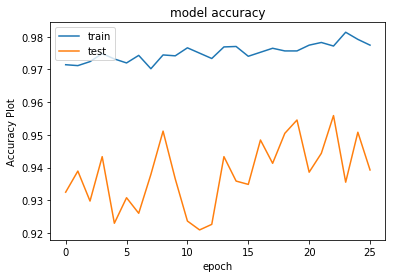

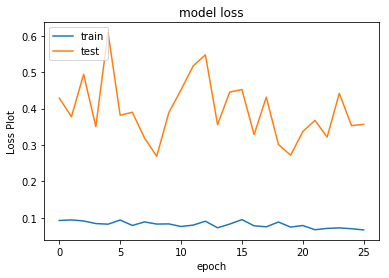

In [0]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 530        0  ...                   0                 7
SITTING                  1      443  ...                   0                 7
STANDING                 0       78  ...                   0                 2
WALKING                  0        0  ...                  26                 3
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        0  ...                  13               458

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 249us/step


In [0]:
score

[0.3568655761598743, 0.9392602646759416]

# 2. CNN Model

In [0]:
from keras.models import Sequential
import keras
from keras.layers import LSTM, Conv1D, TimeDistributed, MaxPooling1D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
    
timesteps = 128
input_dim = 9
n_classes = 6
model = Sequential()
# Configuring the parameters
model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='relu',padding = 'same', input_shape = (timesteps,input_dim)))
model.add(MaxPooling1D(pool_size=2))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(Dropout(0.75))

model.add(Conv1D(filters = 1024, kernel_size=4,
                 activation='sigmoid',padding = 'same'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Conv1D(filters = 1024, kernel_size=4,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
model.add(BatchNormalization())
model.add(Dropout(1))

model.add(Conv1D(filters = 512, kernel_size=2,
             activation='sigmoid',padding = 'same'))
#         model.add(MaxPooling1D(pool_size={{choice([1,2,3])}}))
# model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation='sigmoid'))
# model.add(Dropout(0))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.7))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
# Adding a dense output layer with sigmoid activation
model.add(Dropout(0.10))
model.add(Dense(n_classes, activation='softmax'))

# adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_201 (Conv1D)          (None, 128, 1024)         37888     
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 64, 1024)          0         
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 64, 1024)          4195328   
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 21, 1024)          0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 21, 1024)          4096      
_________________________________________________________________
dropout_345 (Dropout)        (None, 21, 1024)          0         
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 21, 1024)          4195328   
__________

In [0]:
history = model.fit(X_train, Y_train,
          batch_size=16,
          nb_epoch=26,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 7352 samples, validate on 2947 samples
Epoch 1/26
 - 16s - loss: 0.1008 - acc: 0.9650 - val_loss: 0.3108 - val_acc: 0.9372
Epoch 2/26
 - 16s - loss: 0.1044 - acc: 0.9621 - val_loss: 0.3387 - val_acc: 0.9335
Epoch 3/26
 - 16s - loss: 0.0941 - acc: 0.9686 - val_loss: 0.4604 - val_acc: 0.9216
Epoch 4/26
 - 16s - loss: 0.1002 - acc: 0.9656 - val_loss: 0.3405 - val_acc: 0.9372
Epoch 5/26
 - 16s - loss: 0.1028 - acc: 0.9687 - val_loss: 0.3489 - val_acc: 0.9328
Epoch 6/26
 - 16s - loss: 0.1010 - acc: 0.9669 - val_loss: 0.3063 - val_acc: 0.9427
Epoch 7/26
 - 16s - loss: 0.0983 - acc: 0.9676 - val_loss: 0.3478 - val_acc: 0.9352
Epoch 8/26
 - 16s - loss: 0.0996 - acc: 0.9671 - val_loss: 0.3539 - val_acc: 0.9301
Epoch 9/26
 - 16s - loss: 0.0977 - acc: 0.9665 - val_loss: 0.2651 - val_acc: 0.9447
Epoch 10/26
 - 16s - loss: 0.1045 - acc: 0.9683 - val_loss: 0.3146 - val_acc: 0.9287
Epoch 11/26
 - 16s - loss: 0.0997 - acc: 0.9657 - val_loss: 0.2891 - val_acc: 0.9379
Epoch 12/26
 - 16s - loss:

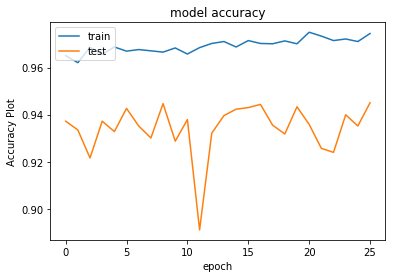

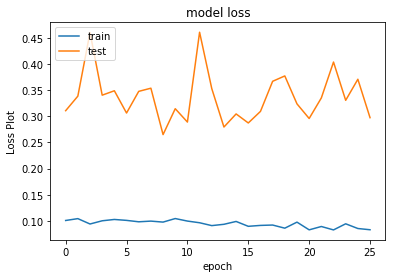

In [0]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      392  ...                   0                 1
STANDING                 0       17  ...                   0                 2
WALKING                  0        0  ...                  25                 0
WALKING_DOWNSTAIRS       0        0  ...                 411                 9
WALKING_UPSTAIRS         0        0  ...                   9               461

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 376us/step


In [0]:
score

[0.29747371452317173, 0.9450288428910757]

In [0]:
X_train.shape

(7352, 128, 9)

# 3. LSTM Model

In [10]:
model = Sequential()
# Configuring the parameters
model.add(LSTM(200, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(Dropout(0.75))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.75))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.75))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.75))
# Adding a dense output layer with sigmoid activation
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.75))
model.add(Dense(n_classes, activation='softmax'))

# adam = keras.optimizers.Adam(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
rmsprop = keras.optimizers.RMSprop(lr=10**-4)
# sgd = keras.optimizers.SGD(lr={{choice([10**-4,10**-3, 10**-2, 10**-1])}})

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=rmsprop)
model.summary()

W0627 14:07:24.449820 140227015829376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 14:07:24.512139 140227015829376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 14:07:24.520497 140227015829376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 14:07:24.876339 140227015829376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0627 14:07:24.889142 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 200)          168000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 200)          320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 200)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 200)          320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 200)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
__________

In [13]:
history = model.fit(X_train, Y_train,
          batch_size=16,
          nb_epoch=30,
          verbose=2,
          validation_data=(X_test, Y_test))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
 - 397s - loss: 0.1025 - acc: 0.9668 - val_loss: 0.5713 - val_acc: 0.9172
Epoch 2/30
 - 398s - loss: 0.1002 - acc: 0.9686 - val_loss: 0.5611 - val_acc: 0.9111
Epoch 3/30
 - 396s - loss: 0.0986 - acc: 0.9675 - val_loss: 0.5544 - val_acc: 0.9220
Epoch 4/30
 - 395s - loss: 0.1022 - acc: 0.9679 - val_loss: 0.6293 - val_acc: 0.9125
Epoch 5/30
 - 395s - loss: 0.1045 - acc: 0.9661 - val_loss: 0.5276 - val_acc: 0.9209
Epoch 6/30
 - 395s - loss: 0.1008 - acc: 0.9693 - val_loss: 0.5803 - val_acc: 0.9131
Epoch 7/30
 - 395s - loss: 0.0927 - acc: 0.9699 - val_loss: 0.5536 - val_acc: 0.9247
Epoch 8/30
 - 395s - loss: 0.0950 - acc: 0.9689 - val_loss: 0.5690 - val_acc: 0.9267
Epoch 9/30
 - 395s - loss: 0.0974 - acc: 0.9689 - val_loss: 0.5748 - val_acc: 0.9220
Epoch 10/30
 - 396s - loss: 0.1004 - acc: 0.9703 - val_loss: 0.7173 - val_acc: 0.9179
Epoch 11/30
 - 396s - loss: 0.0976 - acc: 0.9714 - val_loss: 0.6087 - val_acc: 0.9192
Epoch 12/30
 - 

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train Accuracy", "Test Accuracy"]

x.add_row(["Conv model", 0.9774, 0.9393])
x.add_row(["Conv model", 0.9744, 0.9450])
x.add_row(["LSTM model", 0.9766, 0.9162])


print(x.get_string(title="Multiple LSTM Model"),'\n')

+------------+----------------+---------------+
|   Model    | Train Accuracy | Test Accuracy |
+------------+----------------+---------------+
| Conv model |     0.9774     |     0.9393    |
| Conv model |     0.9744     |     0.945     |
| LSTM model |     0.9766     |     0.9162    |
+------------+----------------+---------------+ 

